# Data pre-processing

The original data provided is stored in the raw_count folder. We manually edits these file into `all_count.xlsx`. In this script we first export this data in a csv file to be read more quickly in the ANN


In [128]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Old data

Formatted manually


In [109]:
do = pd.concat([
    pd.read_excel("../data/count_2021.xlsx", sheet_name="1966-2013"),
    pd.read_excel("../data/count_2021.xlsx", sheet_name="2014-2016"),
    pd.read_excel("../data/count_2021.xlsx", sheet_name="2017-2021")])

# Sort by date
do = do.sort_values('date')

# Compute start and end
do['startTime'] = pd.to_datetime(do['startTime'], format='%H:%M:%S').dt.time
do['start'] = do['date'] + pd.to_timedelta(do['startTime'].astype(str))
do['endTime'] = pd.to_datetime(do['endTime'], format='%H:%M:%S').dt.time
do['end'] = do['date'] + pd.to_timedelta(do['endTime'].astype(str))

# Keep only relevant column
do = do[["species", "date", "count", "start", "end"]]

# Generate the 0 species list within hour
# NOT DONE

# Sum count of same species-time interval
do = do.groupby(["species", "date", "start", "end"]).agg({'count' : 'sum'}).reset_index()

In [124]:
do[do.start >= do.end]

,species,date,start,end,count


## Trektellen data

Exported from website every year.

Read all file and merge into a single file.


In [110]:
dn = []
for y in range(2022, 2023):
    dnn = pd.merge(pd.read_excel(f"../data/raw_count/Trektellen_data_2422_{y}.xlsx"), 
                  pd.read_excel(f"../data/raw_count/Trektellen_headerdata_2422_{y}.xlsx"),
                  left_on="countid", right_on = "id")
    dn.append(dnn)
dn = pd.concat(dn, ignore_index=True)

dn["startDay"] = pd.to_datetime(dn["start"])
dn["endDay"] = pd.to_datetime(dn["stop"])
dn["datetime"] = pd.to_datetime(dn["date"] + " " + dn["timestamp"])

Add taxonomy information to retrieve species name similar to old data.


In [111]:
dn = pd.merge(dn, 
                pd.read_csv(f"../data/taxonomy.csv"),
                how="left",
                left_on="speciesid", right_on = "trektellen_species_id")
# Debug species
# print(df[["speciesname", "speciesid"]][df["species"].isna()].drop_duplicates())

Fix issue with datetime before start or after end

1. correct timing within 10 minute of start and end.
2. Ignore others.


In [112]:
# Try to fix datetime before start or after end with a tolerance of 10 min
id = (dn["datetime"] < dn["startDay"]) & (abs(dn["datetime"] - dn["startDay"]) < pd.Timedelta(minutes=10))
dn.loc[id,"datetime"] = dn.loc[id,"startDay"]
id = (dn["datetime"] >= dn["endDay"]) & (abs(dn["datetime"] - dn["endDay"]) < pd.Timedelta(minutes=10))
dn.loc[id,"datetime"] = dn.loc[id,"endDay"]-pd.Timedelta(minutes=1)

# Ignore the other data
id = (dn["datetime"] < dn["startDay"]) | (dn["datetime"] > dn["endDay"])
print(sum(id))
dn = dn[~id]

2


Create the start and end column to build list of 1hr


In [113]:
dn["datetime_floor"] = dn["datetime"].dt.floor("h")
dn["datetime_ceil"] = (dn["datetime"]+pd.Timedelta(minutes=1)).dt.ceil("h")
dn["start"] = dn[["datetime_floor","startDay"]].max(axis=1)
dn["end"] = dn[["datetime_ceil","endDay"]].min(axis=1)
dn["duration"] = dn["end"]-dn["start"]

In [114]:
dn["count"] = dn["direction1"] + dn["direction2"]

In [115]:
dn = dn[["species","date", "count", "start", "end", "startDay", "endDay", "datetime", "duration"]]

In [121]:
dn[dn["duration"]<pd.to_timedelta(60*10,unit='s')]

,species,date,count,start,end,startDay,endDay,datetime,duration
855,Aigle royal,2022-08-14,0,2022-08-14 07:51:00,2022-08-14 08:00:00,2022-08-14 07:51:00,2022-08-14 11:10:00,2022-08-14 07:58:51,0 days 00:09:00
1010,Bondrée apivore,2022-08-21,11,2022-08-21 19:00:00,2022-08-21 19:05:00,2022-08-21 07:29:00,2022-08-21 19:05:00,2022-08-21 19:00:27,0 days 00:05:00
1045,Busard des roseaux,2022-08-21,1,2022-08-21 19:00:00,2022-08-21 19:05:00,2022-08-21 07:29:00,2022-08-21 19:05:00,2022-08-21 19:04:00,0 days 00:05:00
1046,Busard des roseaux,2022-08-21,1,2022-08-21 19:00:00,2022-08-21 19:05:00,2022-08-21 07:29:00,2022-08-21 19:05:00,2022-08-21 19:04:00,0 days 00:05:00
6068,Grande Aigrette,2022-10-08,10,2022-10-08 19:00:00,2022-10-08 19:05:00,2022-10-08 07:38:00,2022-10-08 19:05:00,2022-10-08 19:01:39,0 days 00:05:00
6188,Bergeronnette grise,2022-10-08,17,2022-10-08 19:00:00,2022-10-08 19:05:00,2022-10-08 07:38:00,2022-10-08 19:05:00,2022-10-08 19:01:14,0 days 00:05:00


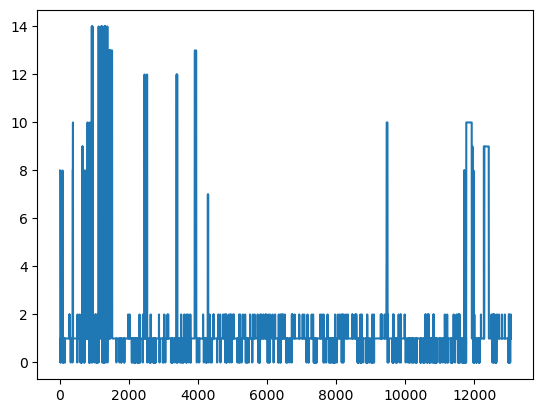

In [118]:
plt.plot((dn["duration"]).astype('timedelta64[s]')/60/60)

## Merge Old and Trektellen data


In [122]:
don = pd.concat([do, dn[["species", "date", "count", "start", "end"]]], ignore_index=True)

In [123]:
don.to_csv("../data/all_count_processed.csv", index = False)

---

## Visual

### Species

Filter list of species for raptor species (non-slash/spuh). The only issue would be Red/Black Kite, Buteo sp. and Buse ou Bondrée


In [125]:
tax = pd.read_csv("../data/taxonomy.csv")
tax = tax[tax['family'].isin(['Accipitridae (Hawks, Eagles, and Kites)', 'Pandionidae (Osprey)', 'Falconidae (Falcons and Caracaras)'])]
tax = tax[tax['category'] == 'species']
tax

,species,trektellen_species_id,match_to_ebird,species_code,taxon_concept_id,category,English name,scientific name,order,family
1,Aigle botté,NaN,exact,booeag1,avibase-4B8CC285,species,Booted Eagle,Hieraaetus pennatus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
2,Aigle criard,NaN,exact,grseag1,avibase-BAC4CA22,species,Greater Spotted Eagle,Clanga clanga,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
3,Aigle des steppes,NaN,exact,steeag1,avibase-A635F565,species,Steppe Eagle,Aquila nipalensis,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
6,Aigle pomarin,NaN,exact,leseag1,avibase-C2565B65,species,Lesser Spotted Eagle,Clanga pomarina,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
8,Aigle royal,107.0,exact,goleag,avibase-5F8E7CA8,species,Golden Eagle,Aquila chrysaetos,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
16,Autour des palombes,99.0,exact,norgos1,avibase-95DD1855,species,Eurasian Goshawk,Accipiter gentilis,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
18,Balbuzard pêcheur,109.0,exact,osprey,avibase-1327AC55,species,Osprey,Pandion haliaetus,Accipitriformes,Pandionidae (Osprey)
31,Bondrée apivore,86.0,exact,euhbuz1,avibase-ED5A7E8F,species,European Honey-buzzard,Pernis apivorus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
41,Busard cendré,98.0,exact,monhar1,avibase-63B6412E,species,Montagu's Harrier,Circus pygargus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"
42,Busard des roseaux,95.0,exact,wemhar1,avibase-E2A19474,species,Western Marsh Harrier,Circus aeruginosus,Accipitriformes,"Accipitridae (Hawks, Eagles, and Kites)"


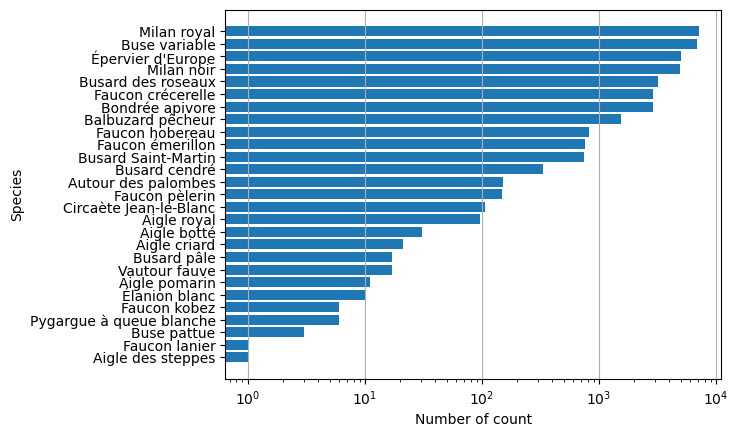

In [126]:
species_counts = don[don.species.isin(tax.species)].species.value_counts()
plt.barh(species_counts.index, species_counts.values, log=True)
plt.ylabel("Species")
plt.xlabel("Number of count")
plt.gca().invert_yaxis()
plt.gca().grid(axis='x')
plt.show()